In [1]:
import mdtraj as md
from ase import Atoms
import nglview as nv
import networkx as nx

import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm


In [2]:

import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, SAGPooling, InnerProductDecoder
import torch_geometric.data as data
from torch_geometric.utils.convert import to_networkx
import torch.optim.lr_scheduler as lr_scheduler




In [3]:
all_frames = md.load_xtc("../simulation/npt.xtc", top="../simulation/box.gro")


In [11]:
all_frames_fatures = []

for i in tqdm(range(all_frames.xyz.shape[0])):
    mol_com_pos = []

    for res in all_frames.top.residues:
        # print(res.index,end=" ")
        pos = []
        for atom in res.atoms:
            # print(atom.index,"-->" , frame.xyz[0][atom.index],end=" ")
            pos.append(all_frames.xyz[i][atom.index])
        mol_com_pos.append(np.mean(pos,axis=0))
        
        # print()
    mol_com_pos = np.array(mol_com_pos).astype(np.float32)  
    all_frames_fatures.append(mol_com_pos)

all_frames_fatures = np.array(all_frames_fatures).astype(np.float32)
print(all_frames_fatures.shape)

100%|██████████| 51/51 [00:00<00:00, 325.43it/s]

(51, 101, 3)


In [93]:
print(dir(all_frames.topology.residue(0)))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_atoms', 'atom', 'atoms', 'atoms_by_name', 'chain', 'code', 'index', 'is_nucleic', 'is_protein', 'is_water', 'n_atoms', 'name', 'resSeq', 'segment_id']


In [94]:
n_frames = all_frames.xyz.shape[0]
n_atoms = all_frames.topology.residue(0).n_atoms
n_mols = all_frames.topology.n_residues

In [95]:
print("number of molecules",n_mols)
print("number of atoms in molecule",n_atoms)
print("number of frames",n_frames)

number of molecules 101
number of atoms in molecule 4
number of frames 51


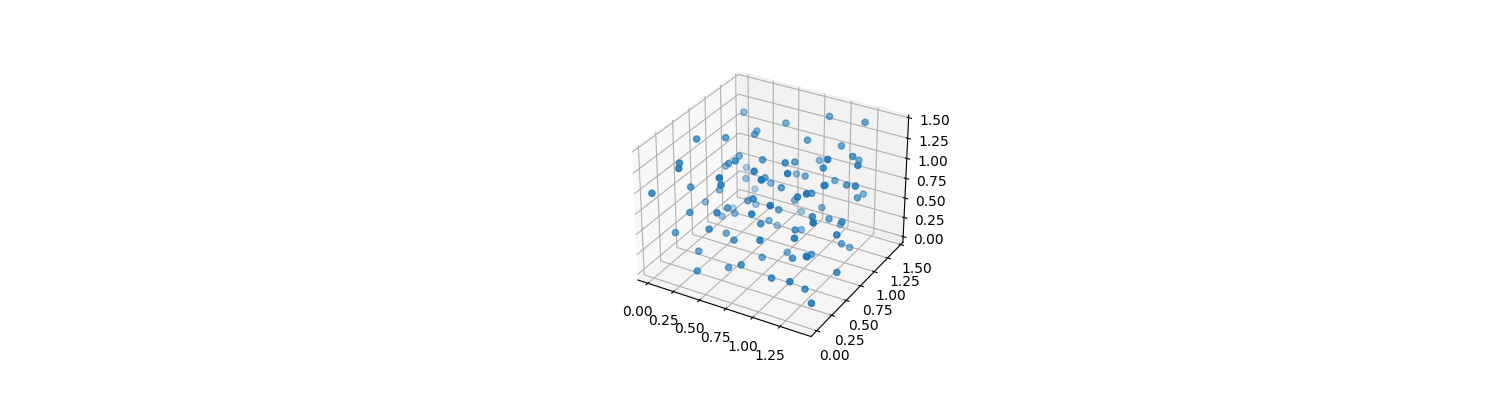

In [96]:
%matplotlib widget

frame = 10

fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(projection='3d')
ax1.scatter(all_frames_fatures[frame][:,0],all_frames_fatures[frame][:,1],all_frames_fatures[frame][:,2])
plt.show()

In [97]:
def convert_to_adj(edge_index, num_nodes=None):
    if num_nodes is None:
        num_nodes = edge_index.max() + 1
    adj = torch.zeros(num_nodes, num_nodes)
    adj[edge_index[0], edge_index[1]] = 1
    return adj

def convert_to_edge_index(adj):
    edge_index = adj.nonzero().t()
    return edge_index

In [98]:
cutoff = 0.5

all_edge_list = []
for frame_i in range(n_frames):
    from_list = []
    to_list = []

    for i in range(len(all_frames_fatures[frame_i])):
        for j in range(i+1,len(all_frames_fatures[frame_i])):
            if np.linalg.norm(all_frames_fatures[frame_i][i]-all_frames_fatures[frame_i][j]) < cutoff:
                # print(i,j,np.linalg.norm(mol_com_pos[i]-mol_com_pos[j]))
                from_list.append(i)
                to_list.append(j)

                to_list.append(i)
                from_list.append(j)

    edge_list = np.array([from_list,to_list]).astype(np.int64)
    all_edge_list.append(edge_list)

print(len(all_edge_list))

51


/tmp/ipykernel_116556/887929909.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15,10))


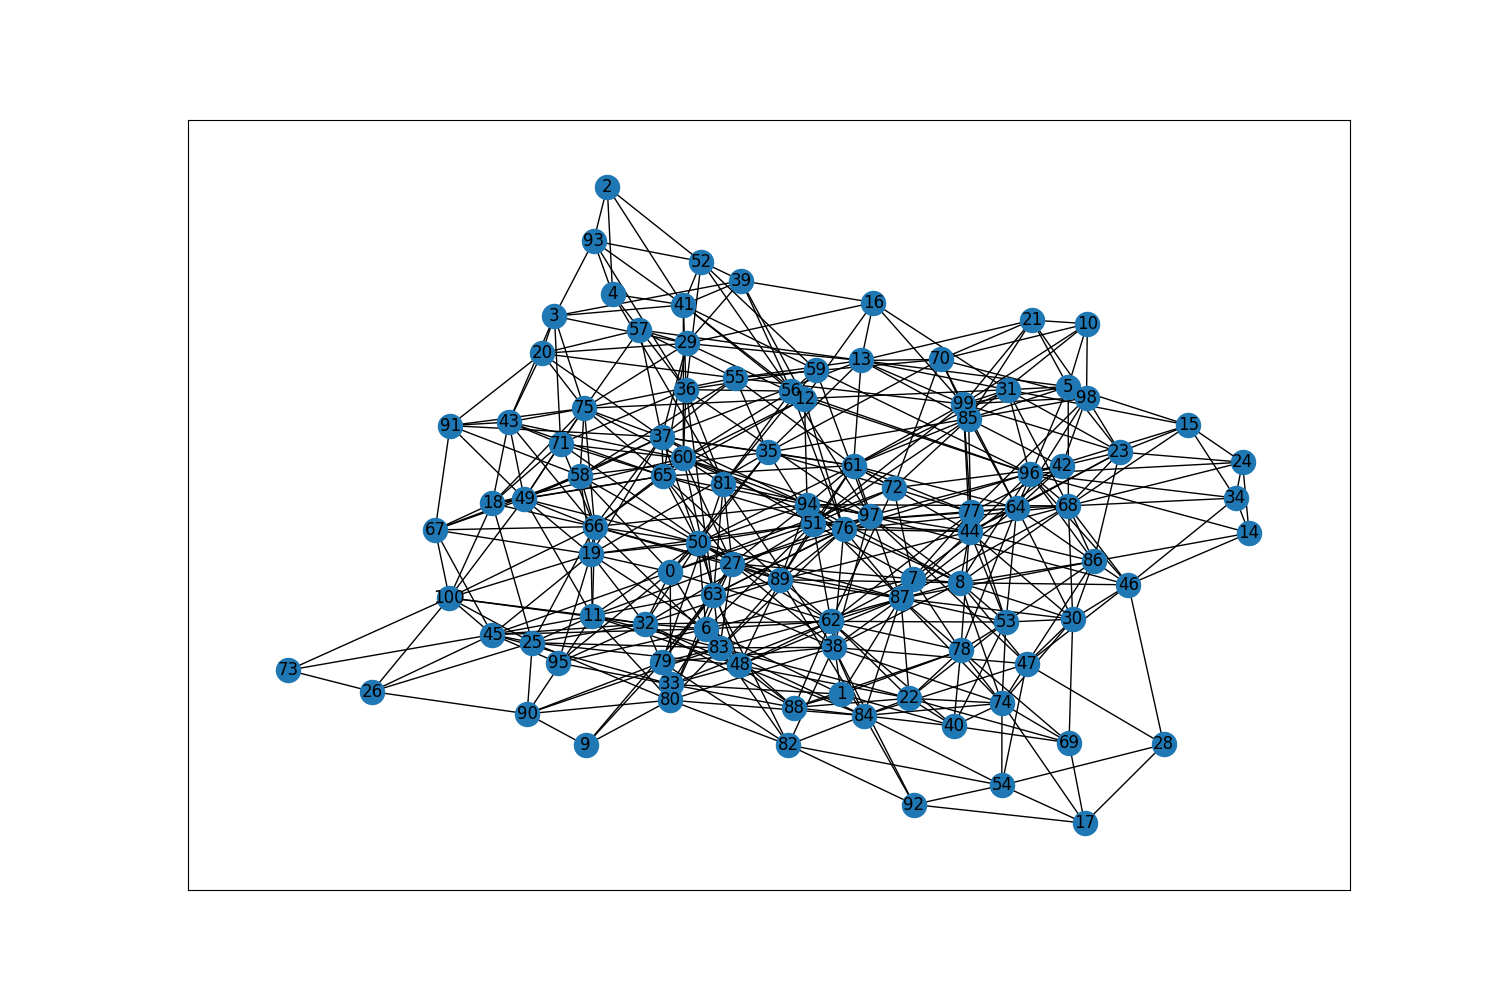

In [99]:
%matplotlib widget

frame = 10

plt.figure(figsize=(15,10))
adj_binary = convert_to_adj(all_edge_list[frame], num_nodes=101)
indices = torch.where(adj_binary)
G = nx.Graph()
edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
G.add_edges_from(edges)
nx.draw_networkx(G)


### Converting to pytorch graph object

In [100]:
graphs = []
for frame in range(n_frames):
    g = data.Data(x=torch.tensor(all_frames_fatures[frame]).float(), edge_index=torch.tensor(all_edge_list[frame]).long(), y=torch.tensor([0]))
    graphs.append(g)

print(graphs[0])

Data(x=[101, 3], edge_index=[2, 1158], y=[1])


## Model

In [101]:
from typing import Optional, Tuple

import torch
from torch import Tensor
from torch.nn import Module

from torch_geometric.nn.inits import reset
from torch_geometric.utils import negative_sampling

EPS = 1e-15
MAX_LOGSTD = 10
edgeShape = None
featureShape = None


class InnerProductDecoder(torch.nn.Module):
    r"""The inner product decoder from the `"Variational Graph Auto-Encoders"
    <https://arxiv.org/abs/1611.07308>`_ paper

    .. math::
        \sigma(\mathbf{Z}\mathbf{Z}^{\top})

    where :math:`\mathbf{Z} \in \mathbb{R}^{N \times d}` denotes the latent
    space produced by the encoder."""

    def forward(self, z: Tensor, edge_index: Tensor,
                sigmoid: bool = True) -> Tensor:
        r"""Decodes the latent variables :obj:`z` into edge probabilities for
        the given node-pairs :obj:`edge_index`.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        value = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
        return torch.sigmoid(value) if sigmoid else value

    def forward_all(self, z: Tensor, sigmoid: bool = True) -> Tensor:
        r"""Decodes the latent variables :obj:`z` into a probabilistic dense
        adjacency matrix.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        adj = torch.matmul(z, z.t())
        return torch.sigmoid(adj) if sigmoid else adj


class GAE(torch.nn.Module):
    r"""The Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper based on user-defined encoder and decoder models.

    Args:
        encoder (torch.nn.Module): The encoder module.
        decoder (torch.nn.Module, optional): The decoder module. If set to
            :obj:`None`, will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """

    def __init__(self, encoder: Module, decoder: Optional[Module] = None):
        super().__init__()
        self.encoder = encoder
        self.decoder = InnerProductDecoder() if decoder is None else decoder
        GAE.reset_parameters(self)

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        reset(self.encoder)
        reset(self.decoder)

    def forward(self, *args, **kwargs) -> Tensor:  # pragma: no cover
        r"""Alias for :meth:`encode`."""
        return self.encoder(*args, **kwargs)

    def encode(self, *args, **kwargs) -> Tensor:
        r"""Runs the encoder and computes node-wise latent variables."""
        return self.encoder(*args, **kwargs)

    def decode(self, *args, **kwargs) -> Tensor:
        r"""Runs the decoder and computes edge probabilities."""
        return self.decoder(*args, **kwargs)

    def recon_loss(self, z: Tensor, pos_edge_index: Tensor,
                   neg_edge_index: Optional[Tensor] = None) -> Tensor:
        r"""Given latent variables :obj:`z`, computes the binary cross
        entropy loss for positive edges :obj:`pos_edge_index` and negative
        sampled edges.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (torch.Tensor): The positive edges to train against.
            neg_edge_index (torch.Tensor, optional): The negative edges to
                train against. If not given, uses negative sampling to
                calculate negative edges. (default: :obj:`None`)
        """
        pos_loss = -torch.log(
            self.decoder(z, pos_edge_index, sigmoid=True)[0] + EPS).mean()

        if neg_edge_index is None:
            neg_edge_index = negative_sampling(pos_edge_index, z.size(0))
        neg_loss = -torch.log(1 -
                              self.decoder(z, neg_edge_index.long(), sigmoid=True)[0] +
                              EPS).mean()

        return pos_loss + neg_loss

    def test(self, z: Tensor, pos_edge_index: Tensor,
             neg_edge_index: Tensor) -> Tuple[Tensor, Tensor]:
        r"""Given latent variables :obj:`z`, positive edges
        :obj:`pos_edge_index` and negative edges :obj:`neg_edge_index`,
        computes area under the ROC curve (AUC) and average precision (AP)
        
        scores.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (torch.Tensor): The positive edges to evaluate
                against.
            neg_edge_index (torch.Tensor): The negative edges to evaluate
                against.
        """
        from sklearn.metrics import average_precision_score, roc_auc_score

        pos_y = z.new_ones(pos_edge_index.size(1))
        neg_y = z.new_zeros(neg_edge_index.size(1))
        y = torch.cat([pos_y, neg_y], dim=0)

        pos_pred = self.decoder(z, pos_edge_index, sigmoid=True)
        neg_pred = self.decoder(z, neg_edge_index, sigmoid=True)
        pred = torch.cat([pos_pred, neg_pred], dim=0)

        y, pred = y.detach().cpu().numpy(), pred.detach().cpu().numpy()

        return roc_auc_score(y, pred), average_precision_score(y, pred)


class VGAE(GAE):
    r"""The Variational Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper.

    Args:
        encoder (torch.nn.Module): The encoder module to compute :math:`\mu`
            and :math:`\log\sigma^2`.
        decoder (torch.nn.Module, optional): The decoder module. If set to
            :obj:`None`, will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """

    def __init__(self, encoder: Module, decoder: Optional[Module] = None):
        super().__init__(encoder, decoder)

    def reparametrize(self, mu: Tensor, logstd: Tensor) -> Tensor:
        if self.training:
            return mu + torch.randn_like(logstd) * torch.exp(logstd)
        else:
            return mu
    
    def encode(self, *args, **kwargs) -> Tensor:
        """"""
        self.__mu__, self.__logstd__, self.edge_index = self.encoder(
            *args, **kwargs)
        self.__logstd__ = self.__logstd__.clamp(max=MAX_LOGSTD)
        z = self.reparametrize(self.__mu__, self.__logstd__)
        return z, self.edge_index

    def kl_loss(self, mu: Optional[Tensor] = None,
                logstd: Optional[Tensor] = None) -> Tensor:
        r"""Computes the KL loss, either for the passed arguments :obj:`mu`
        and :obj:`logstd`, or based on latent variables from last encoding.

        Args:
            mu (torch.Tensor, optional): The latent space for :math:`\mu`. If
                set to :obj:`None`, uses the last computation of :math:`\mu`.
                (default: :obj:`None`)
            logstd (torch.Tensor, optional): The latent space for
                :math:`\log\sigma`.  If set to :obj:`None`, uses the last
                computation of :math:`\log\sigma^2`. (default: :obj:`None`)
        """
        mu = self.__mu__ if mu is None else mu
        logstd = self.__logstd__ if logstd is None else logstd.clamp(
            max=MAX_LOGSTD)
        return -0.5 * torch.mean(
            torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1))


In [102]:
def norm_g(g):
    degrees = torch.sum(g, 1)
    g = g / degrees
    return g


def top_k_graph(scores, g, h, k):
    num_nodes = g.shape[0]
    values, idx = torch.topk(scores, max(2, int(k*num_nodes)))
    new_h = h[idx, :]
    values = torch.unsqueeze(values, -1)
    new_h = torch.mul(new_h, values)
    un_g = g.bool().float()
    un_g = torch.matmul(un_g, un_g).bool().float()
    un_g = un_g[idx, :]
    un_g = un_g[:, idx]
    g = norm_g(un_g)
    return g, new_h, idx

class Pool(torch.nn.Module):

    def __init__(self, k, in_dim, p):
        super(Pool, self).__init__()
        self.k = k
        self.sigmoid = torch.nn.Sigmoid()
        self.proj = torch.nn.Linear(in_dim, 1)
        self.drop = torch.nn.Dropout(p=p) if p > 0 else torch.nn.Identity()

    def forward(self, g, h):
        Z = self.drop(h)
        weights = self.proj(Z).squeeze()
        scores = self.sigmoid(weights)
        return top_k_graph(scores, g, h, self.k)


class Unpool(torch.nn.Module):

    def __init__(self, *args):
        super(Unpool, self).__init__()

    def forward(self, h, edge_indices,factor=1):
        # add zeros to h factor times
        global featureShape
        h = torch.cat([h, torch.zeros(max(featureShape[0]- h.shape[0],0), h.shape[1]).to(h.device)], dim=0)
        return h

class Unpool2(torch.nn.Module):
    def __init__(self, *args):
        super(Unpool2, self).__init__()

    def forward(self, batch, unpool_ratio):
        num_nodes = batch[-1].item() + 1
        expanded_batch = batch.unsqueeze(1).repeat(1, unpool_ratio)  # Repeat batch indices
        expanded_batch = expanded_batch.view(-1)  # Flatten the batch indices
        return  expanded_batch




In [103]:
import torch.nn.functional as F



class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2*out_channels, 1 * out_channels)
        self.pool = SAGPooling(out_channels, 0.5)
        self.conv_mu = GCNConv(1 * out_channels, out_channels)
        self.conv_logstd = GCNConv(1 * out_channels, out_channels)

    def forward(self, x, edge_index):
        global edgeShape, featureShape
        # print("input:",x.shape, edge_index.shape)
        x = self.conv1(x, edge_index)
        x = F.silu(x)
        # print("conv1:",x.shape, edge_index.shape)
        x = self.conv2(x, edge_index)
        x = F.silu(x)
        # print("conv2:",x.shape, edge_index.shape)
        edgeShape = edge_index.shape
        featureShape = x.shape
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index), edge_index


In [104]:
class VariationalGCNDecoder(torch.nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, 1 * out_channels)
    def forward(self, x, edge_index, sigmoid=True):
        global edgeShape, featureShape
        # print("input:",x.shape, edge_index.shape)
        x = self.conv1(x, edge_index)
        x = F.silu(x)
        # print("conv1:",x.shape, edge_index.shape)
        x = self.conv2(x, edge_index)
        x = F.silu(x)
        # print("conv2:",x.shape, edge_index.shape)
        return x, edge_index

In [105]:
import os
in_channels = graphs[0].num_features
out_channels = 2
lr = 1e-3
n_epochs = 500
batch_size=2
test_train_split = 0.8
model_name = "InterGVAE_v1.pt"
model_loaded = False
force_train = False

if os.path.exists("./models/"+model_name) and not force_train:
    model = torch.load("./models/"+model_name)
    model_loaded = True
else:
    model = VGAE(VariationalGCNEncoder(in_channels, out_channels),
                VariationalGCNDecoder(out_channels, in_channels))

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.5)

In [ ]:
model

In [106]:
train_loader = DataLoader(graphs[:int(n_frames*test_train_split)], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(graphs[int(n_frames*test_train_split):], batch_size=batch_size, shuffle=True)

In [107]:
lossFxn = torch.nn.MSELoss()
def train():
    model.train()
    model.zero_grad()
    model.float()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    kl_loss_all = 0

    for data in train_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)

        FeatureLoss = lossFxn(decoded_x, data.x)
        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        loss = FeatureLoss + EdgeLoss
        loss = loss 

        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        kl_loss_all += float(model.kl_loss()/data.num_nodes)

        loss.backward()
        optimizer.step()
        
        

    return loss_all / len(train_loader), feature_loss_all / len(train_loader), edge_loss_all / len(train_loader), kl_loss_all / len(train_loader)

In [108]:
lossFxn = torch.nn.MSELoss()
def test():
    model.eval()
    model.zero_grad()
    model.float()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    kl_loss_all = 0

    for data in test_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)

        FeatureLoss = lossFxn(decoded_x, data.x)
        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        loss = FeatureLoss + EdgeLoss
        loss = loss 

        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        kl_loss_all += float(model.kl_loss()/data.num_nodes)

        
        

    return loss_all / len(test_loader), feature_loss_all / len(test_loader), edge_loss_all / len(test_loader), kl_loss_all / len(test_loader)

In [109]:
train_total_losses = []
train_feature_losses = []
train_edge_losses = []
train_kl_losses = []

test_total_losses = []
test_feature_losses = []
test_edge_losses = []
test_kl_losses = []

if model_loaded:        
    print("Pretrained Model Loaded, no training required")
else:
    for epoch in range(1, n_epochs + 1):
        
        train_total_loss, train_feature_loss, train_edge_loss, train_kl_loss = train()
        test_total_loss, test_feature_loss, test_edge_loss, test_kl_loss = test()
        
        print(f"Epoch: {epoch:03d}")
        print(f'\tTrain:\tTotal Loss: {train_total_loss:.4f}, Feature Loss: {train_feature_loss:.4f},  LR: {scheduler.get_last_lr()[0]:.6f}')
        print(f'\tTest: \tTotal Loss: {test_total_loss:.4f}, Feature Loss: {test_feature_loss:.4f}, , LR: {scheduler.get_last_lr()[0]:.6f}')
        


        train_total_losses.append(train_total_loss)
        train_feature_losses.append(train_feature_loss)
        train_edge_losses.append(train_edge_loss)
        train_kl_losses.append(train_kl_loss)

        test_total_losses.append(test_total_loss)
        test_feature_losses.append(test_feature_loss)
        test_edge_losses.append(test_edge_loss)
        test_kl_losses.append(test_kl_loss)
        
        scheduler.step()
    torch.save(model,"./models/"+model_name)

Pretrained Model Loaded, no training required


In [110]:

if not model_loaded:
    plt.figure(figsize=(14, 5))
    plt.plot(test_total_losses, label='Total Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

In [111]:
if not model_loaded:
    plt.figure(figsize=(14, 5))
    plt.plot(test_feature_losses, label='Feature Loss')
    plt.legend()
    plt.title('Feature Loss')
    plt.show()

In [112]:
train_loader = DataLoader(graphs, batch_size=1)
decoded_data=[]
for data in train_loader:
    model.eval()
    z,encoded_edge_index = model.encode(data.x, data.edge_index)
    decoded_data.append(z.detach().numpy())

decoded_data = np.array(decoded_data)

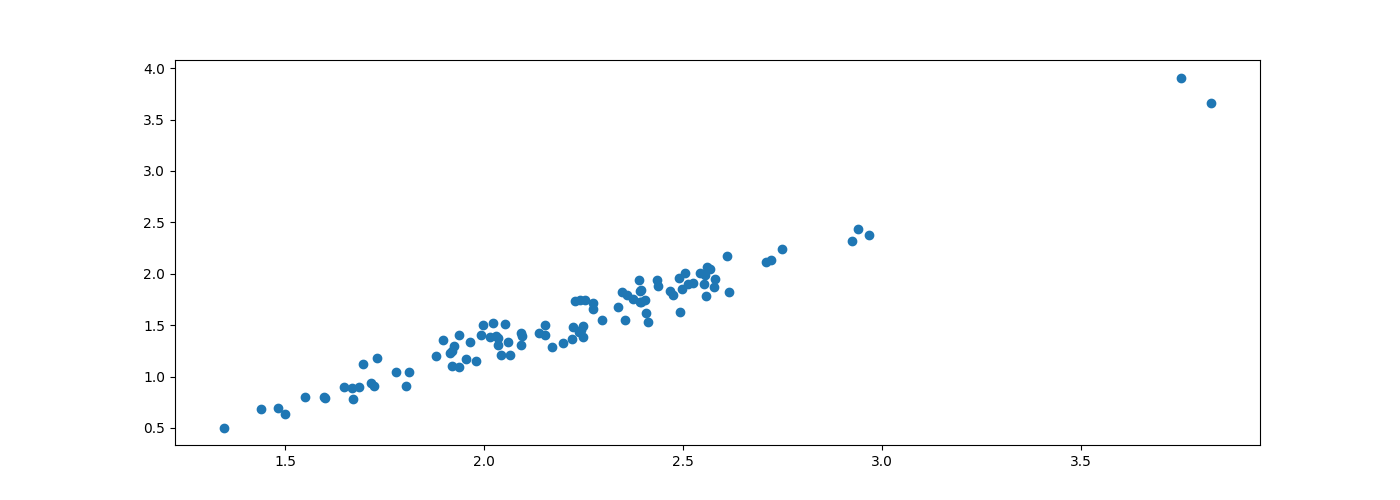

In [113]:
frame = 5
plt.figure(figsize=(14, 5))
data = decoded_data[frame]
plt.scatter(data[:,0], data[:,1])
plt.show()

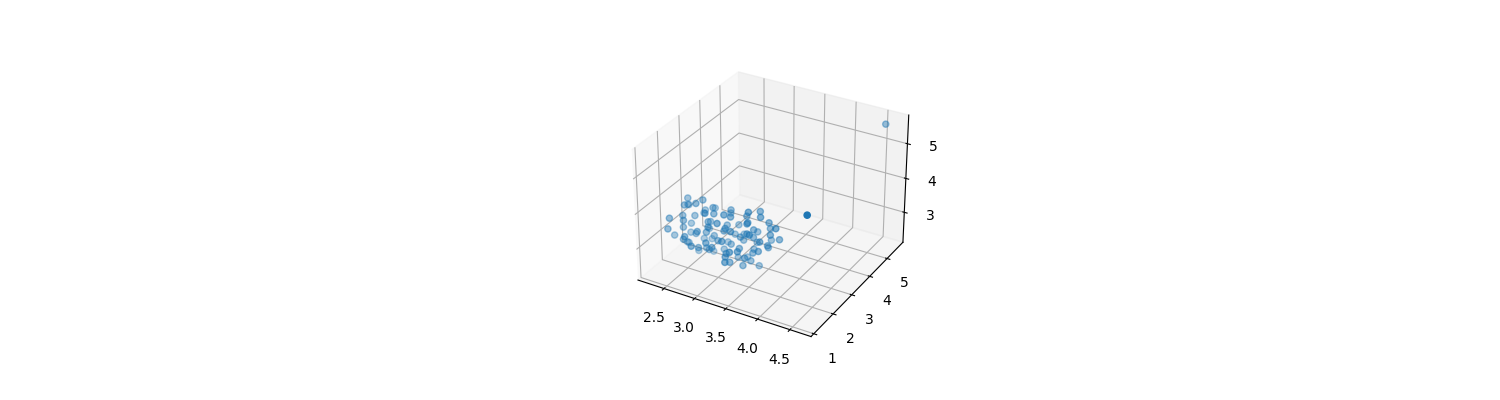

In [114]:
%matplotlib widget


fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(projection='3d')
ax1.scatter(all_frames_fatures[frame][:,0],all_frames_fatures[frame][:,1],all_frames_fatures[frame][:,2])
plt.show()

In [115]:
all_frames_fatures.shape

(51, 101, 3)

In [116]:
crystal_structure = md.load("../simulation/h20_crystal.gro")
crystal_structure.xyz.shape

(1, 404, 3)

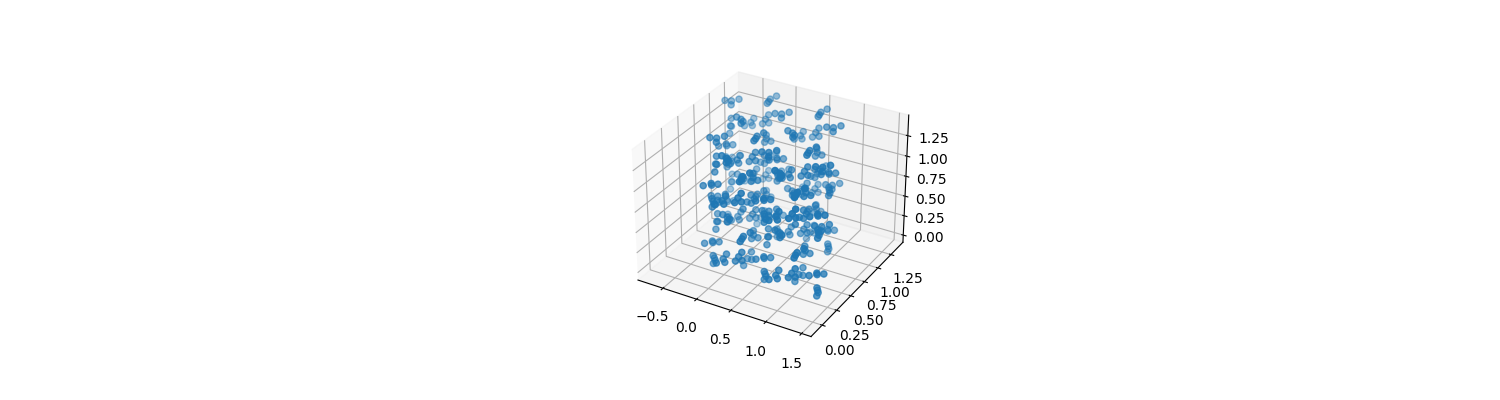

In [117]:
%matplotlib widget


fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(projection='3d')
ax1.scatter(crystal_structure.xyz[0][:,0],crystal_structure.xyz[0][:,1],crystal_structure.xyz[0][:,2])
plt.show()

In [118]:
crystal_structure.xyz[0]
crystal_data = []

# take average of 4 items in list
for i in range(0,len(crystal_structure.xyz[0]),4):
    crystal_data.append(np.mean(crystal_structure.xyz[0][i:i+4],axis=0))

crystal_data = np.array(crystal_data)
crystal_data.shape

(101, 3)

In [119]:
cutoff = 0.5


from_list = []
to_list = []

for i in range(len(crystal_data)):
    for j in range(i+1,len(crystal_data)):
        if np.linalg.norm(crystal_data[i]-crystal_data[j]) < cutoff:
            # print(i,j,np.linalg.norm(mol_com_pos[i]-mol_com_pos[j]))
            from_list.append(i)
            to_list.append(j)

            to_list.append(i)
            from_list.append(j)

crystal_edge_list = np.array([from_list,to_list]).astype(np.int64)

print((crystal_edge_list.shape))

(2, 966)


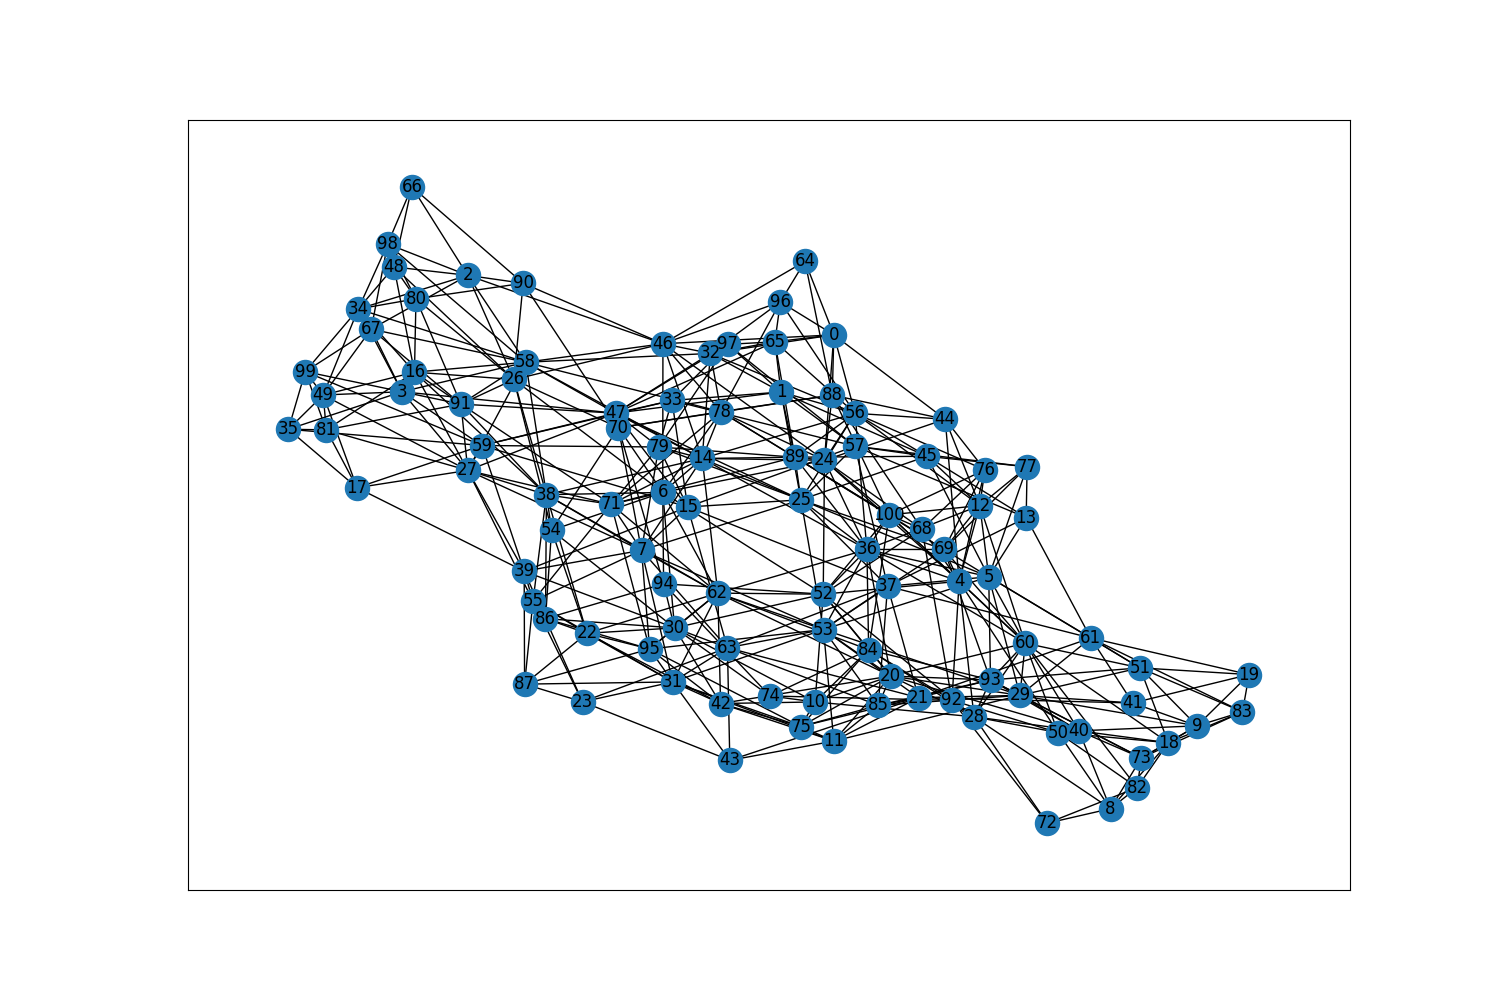

In [120]:
%matplotlib widget
import torch_geometric.data as data

frame = 10

plt.figure(figsize=(15,10))
adj_binary = convert_to_adj(crystal_edge_list, num_nodes=101)
indices = torch.where(adj_binary)
G = nx.Graph()
edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
G.add_edges_from(edges)
nx.draw_networkx(G)


In [121]:
g = data.Data(x=torch.tensor(crystal_data).float(), edge_index=torch.tensor(crystal_edge_list).long(), y=torch.tensor([0]))


In [122]:
train_loader = DataLoader([g], batch_size=1)
decoded_data=[]
for data in train_loader:
    model.eval()
    z,encoded_edge_index = model.encode(data.x, data.edge_index)
    decoded_data.append(z.detach().numpy())

decoded_data = np.array(decoded_data)

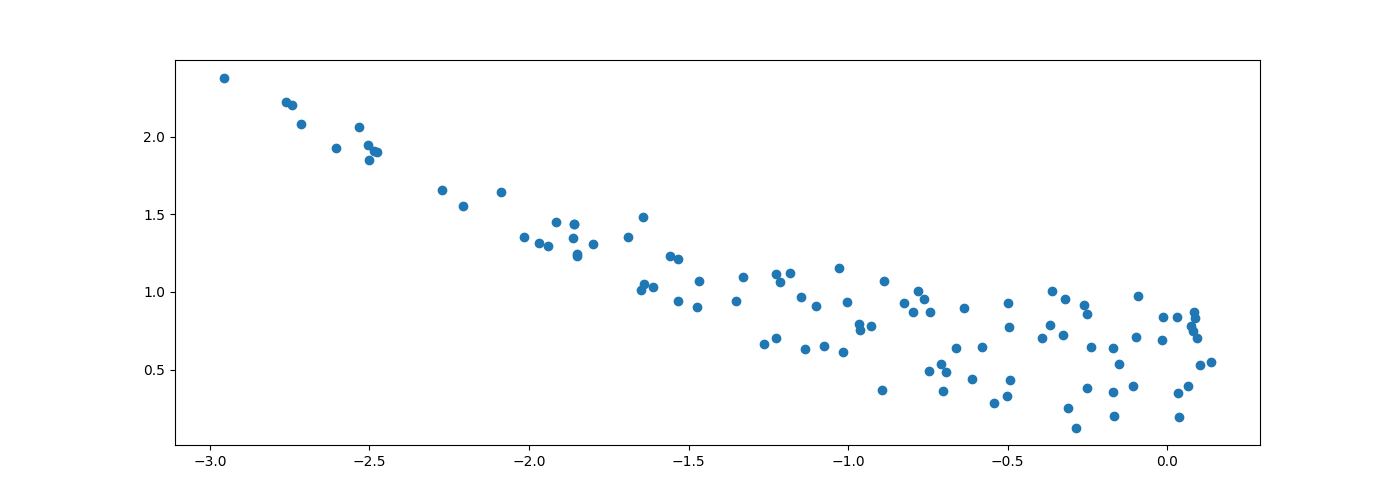

In [123]:
plt.figure(figsize=(14, 5))
data = decoded_data[0]
plt.scatter(data[:,0], data[:,1])
plt.show()